In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import re

from orix import data, io, plot, sampling
from orix.crystal_map import CrystalMap, Phase, PhaseList
from orix.quaternion import Orientation, symmetry
from orix.quaternion.rotation import Rotation
from orix.vector import Vector3d


# We'll want our plots to look a bit larger than the default size
new_params = {
    "figure.facecolor": "w",
    "figure.figsize": (20, 7),
    "lines.markersize": 10,
    "font.size": 15,
    "axes.grid": True,
}
plt.rcParams.update(new_params)

In [2]:
def ReadFieldValues(CasePath,TimeStr,FieldName):
    filePath = CasePath + TimeStr + "/" + FieldName
    
#     Open file and read and split the lines
    with open(filePath) as f:
        lines = f.read().splitlines() 
    
    i = 0
    for line in lines:
        if lines[i] == "(":
            nValues = int(lines[i-1]);
#             print(nValues)
            iStart = i+1;
            
        if lines[i] == ")":
            iEnd = i-1;
        
        i = i+1
    
    fieldValues = np.zeros(nValues)
    
    for i in range(0,nValues):
        fieldValues[i] = float(lines[iStart+i])
    return fieldValues

In [3]:
def getBoundaryStr(CasePath,TimeStr,FieldName):
    filePath = CasePath + TimeStr + "/" + FieldName
    with open(filePath) as f:
        lines = f.read().splitlines() 
    i = 0
    for line in lines:
        if lines[i] == "boundaryField":
            iBoundary = i
        i = i+1

    boundaryLines = lines[iBoundary:-1]
    boundaryStr = ""

    b = 0
    for B in boundaryLines:
        boundaryLines[b] = re.sub("calculated","zeroGradient",B)
        if "value" in B:
            boundaryLines[b]=""
        boundaryStr = boundaryStr + str(boundaryLines[b]) + str("\n")
        b = b+1
    
    boundaryStr = str(boundaryStr)
    return boundaryStr

In [4]:
def ReadVectorFieldValues(CasePath,TimeStr,FieldName):
    filePath = CasePath + TimeStr + "/" + FieldName
    
#     Open file and read and split the lines
    with open(filePath) as f:
        lines = f.read().splitlines() 
    
#     #     iStart=0
# #     iEnd=0
    i = 0
    for line in lines:
        if lines[i] == "(":
            nValues = int(lines[i-1]);
#             print(nValues)
            iStart = i+1;
            
        if lines[i] == "boundaryField":
            iEnd = i-4;
        i = i+1
    print(iStart,lines[iStart])
    print(iEnd,lines[iEnd])
    
    lines = lines[iStart:iEnd+1]
    print(len(lines))
    i =0
    for l in lines:
        lines[i] = lines[i].strip('(')
        lines[i] = lines[i].strip(')')
        lines[i] = lines[i].split()

        j=0
        for c in lines[i]:
            lines[i][j] = float(c)
            j=j+1
        
        i = i+1
    lines = np.array(lines)
    
    return lines

In [5]:
def  writeField(ValueType,CasePath,TimeStr,FieldName,FieldValues,boundaryInfoStr):
    buffer=[]
    buffer.append('/*--------------------------------*- C++ -*----------------------------------*\\')
    buffer.append('|=========                 |                                                 |')
    buffer.append('| \\      /  F ield         | foam-extend: Open Source CFD                    |')
    buffer.append('|  \\    /   O peration     | Version:     4.0                                |')
    buffer.append('|   \\  /    A nd           | Web:         http://www.foam-extend.org         |')
    buffer.append('|    \\/     M anipulation  |                                                 |')
    buffer.append('\*---------------------------------------------------------------------------*/')
    buffer.append('//             THIS FILE WAS CREATED BY D. DREELAN IN MATLAB')
    buffer.append('FoamFile')
    buffer.append('{')
    buffer.append('    version     2.0;')
    buffer.append('    format      ascii;')
#     iStart = len(buffer)
#     i = iStart + 1;

    if ValueType == 'vector':
        buffer.append('    class       volVectorField;')
    elif ValueType == 'scalar':
        buffer.append('    class       volScalarField;')
#     else: # Need to quit out and say not recognised

    buffer.append('    location   "' + TimeStr + '";')
    buffer.append('    object    ' + FieldName + ';')
    buffer.append('}')
    if FieldName == "T":
        buffer.append('dimensions      [0 0 0 1 0 0 0];')
    else:
        buffer.append('dimensions      [0 0 0 0 0 0 0];')
    buffer.append('internalField   nonuniform List<'+str(ValueType)+'>')
    buffer.append(str(len(FieldValues)))
    buffer.append('(')

# %      ADD ALL FIELD VALUES
    if ValueType == 'scalar':
        for v in range(0,len(FieldValues)):
            buffer.append(str(FieldValues[v]))

    elif ValueType == 'vector':
        for v in range(0,len(FieldValues)):
            buffer.append("(" +str(FieldValues[v,0])+" " +str(FieldValues[v,1])+" " +str(FieldValues[v,2])+")")
            
    buffer.append(")")
    buffer.append(";")    
    buffer.append(boundaryInfoStr)

    pathToFile = CasePath + TimeStr + "/" + FieldName
    
    f = open(pathToFile, "a")
    f.truncate()
    for line in buffer:
        f.write(line + "\n")
    f.close()

In [6]:
# % Function for writing RGB values to be viewed in paraview
def  writeField(ValueType,CasePath,TimeStr,FieldName,FieldValues,boundaryStr):
    buffer=[]
    buffer.append('/*--------------------------------*- C++ -*----------------------------------*\\')
    buffer.append('|=========                 |                                                 |')
    buffer.append('| \\      /  F ield         | foam-extend: Open Source CFD                    |')
    buffer.append('|  \\    /   O peration     | Version:     4.0                                |')
    buffer.append('|   \\  /    A nd           | Web:         http://www.foam-extend.org         |')
    buffer.append('|    \\/     M anipulation  |                                                 |')
    buffer.append('\*---------------------------------------------------------------------------*/')
    buffer.append('//             THIS FILE WAS CREATED BY D. DREELAN IN MATLAB')
    buffer.append('FoamFile')
    buffer.append('{')
    buffer.append('    version     2.0;')
    buffer.append('    format      ascii;')
#     iStart = len(buffer)
#     i = iStart + 1;

    if ValueType == 'vector':
        buffer.append('    class       volVectorField;')
    elif ValueType == 'scalar':
        buffer.append('    class       volScalarField;')
#     else: # Need to quit out and say not recognised

    buffer.append('    location   "' + TimeStr + '";')
    buffer.append('    object    ' + FieldName + ';')
    buffer.append('}')
    buffer.append('dimensions      [0 0 0 0 0 0 0];')
    buffer.append('internalField   nonuniform List<'+str(ValueType)+'>')
    buffer.append(str(len(FieldValues)))
    buffer.append('(')

# %      ADD ALL FIELD VALUES
    if ValueType == 'scalar':
        for v in range(0,len(FieldValues)):
            buffer.append(str(FieldValues[v]))

    elif ValueType == 'vector':
        for v in range(0,len(FieldValues)):
            buffer.append("(" +str(FieldValues[v,0])+" " +str(FieldValues[v,1])+" " +str(FieldValues[v,2])+")")
            
    buffer.append(")")
    buffer.append(";")
    
    buffer.append(boundaryStr)
    
#     Buffer is complete, need to print to file
    pathToFile = CasePath + TimeStr + "/" + FieldName
    
    f = open(pathToFile, "a")
    f.truncate()
    for line in buffer:
        f.write(line + "\n")
    f.close()

In [18]:
def genIPF(eulerAngles,symmetryIn):
    rotations = Rotation.from_euler(eulerAngles)
    kwargs = dict(projection="ipf",direction=(1,0,0))
    ipfkey = plot.IPFColorKeyTSL(symmetry.Oh)
    
    ori = Orientation.from_euler(eulerAngles, symmetry=symmetryIn)
    xmap = CrystalMap(rotations=rotations)
    rgb_z = ipfkey.orientation2color(ori)
    return rgb_z

In [37]:
def IPF(CasePath,Time,symmetryIn):
    eulerX = np.radians(ReadFieldValues(CasePath,Time,"eulerX"))
    eulerY = np.radians(ReadFieldValues(CasePath,Time,"eulerY"))
    eulerZ = np.radians(ReadFieldValues(CasePath,Time,"eulerZ"))
    eulerAngles = np.column_stack([eulerX,eulerY,eulerZ])
    
    rgb = genIPF(eulerAngles,symmetryIn)
    
    boundaryStr = getBoundaryStr(CasePath,Time,"eulerX")
    writeField('vector',CasePath,Time,'IPF',rgb,boundaryStr)
    
# # Save the IPF key
#     ipfkey = plot.IPFColorKeyTSL(symmetryIn)
#     io.save("IPFkey.png",ipfkey)
# #     fig = plt.figure(ipfkey)
# #     fig.savefig("Test.png")

In [39]:
DirPath="/Users/dd/foam/dockerShared/cafoamrepo/run/CFDcoupled/paramStudy/"

CaseName="st_P150_V1.5_10um/"
CasePath = DirPath + CaseName
Time="0.000508603"
IPF(CasePath,Time,symmetry.Oh)

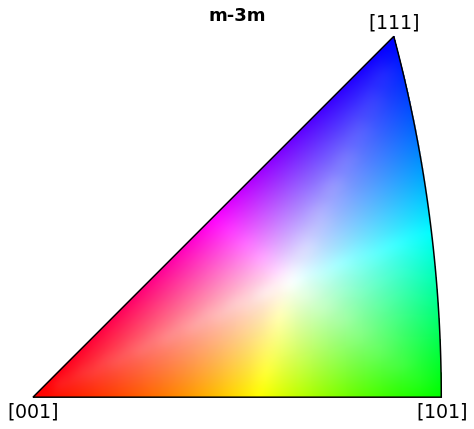

In [10]:
# View available point groups
pg_laue = [
#     symmetry.Ci,
#     symmetry.C2h,
#     symmetry.D2h,
#     symmetry.S6,
#     symmetry.D3d,
#     symmetry.C4h,
#     symmetry.D4h,
#     symmetry.C6h,
#     symmetry.D6h,
#     symmetry.Th,
    symmetry.Oh,
]
for pg in pg_laue:
    ipfkey = plot.IPFColorKeyTSL(pg)
    ipfkey.plot()